Installation Steps:

In [ ]:
# install chromium, its driver, and selenium
!apt update
!apt install libu2f-udev libvulkan1
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb
!wget https://edgedl.me.gvt1.com/edgedl/chrome/chrome-for-testing/118.0.5993.70/linux64/chromedriver-linux64.zip
!unzip -j chromedriver-linux64.zip chromedriver-linux64/chromedriver -d /usr/local/bin/
!pip install selenium chromedriver_autoinstaller

!pip install beautifulsoup4
!pip install pandas
!pip install matplotlib seaborn
!apt-get install -y snapd
!snap install chromium
!pip install nest_asyncio



Get:1 https://dl.google.com/linux/chrome/deb stable InRelease [1,825 B]
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy Release
Get:8 https://dl.google.com/linux/chrome/deb stable/main amd64 Packages [1,089 B]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 2,914 B in 2s (1,810 B/s)
Reading package lists... Done
Building de

Driver Verification :

In [ ]:
!which chromedriver
!chromium-browser --version
!chromedriver --version

/usr/local/bin/chromedriver
/bin/bash: line 1: chromium-browser: command not found
ChromeDriver 118.0.5993.70 (e52f33f30b91b4ddfad649acddc39ab570473b86-refs/branch-heads/5993@{#1216})


Imports :

In [ ]:
import requests
from bs4 import BeautifulSoup as bs
import time
from selenium import webdriver
import chromedriver_autoinstaller
import pandas as pd
from IPython.display import display, Image
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import asyncio
import aiohttp
import nest_asyncio
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
chromedriver_autoinstaller.install()

'/usr/local/lib/python3.10/dist-packages/chromedriver_autoinstaller/129/chromedriver'

Scraping data of the dishes :

In [ ]:
nest_asyncio.apply()
recipes = []

def scrape_calories(soup):

     # Scrape ww_points
    # ww_points_span = soup.find('span', class_='recipe-meta-value recipe-ww-pp icon')
    # ww_points = ww_points_span.text.strip().split(":")[-1].strip() if ww_points_span else "No Calories info"

    # Scrape Calories
    calories_span = soup.find('span', class_='recipe-meta-value value-calories')
    calories = calories_span.text.strip().split(":")[-1].strip() if calories_span else "No Calories info"

    # Scrape Protein
    protein_span = soup.find('span', class_='recipe-meta-value value-protein')
    protein = protein_span.text.strip().split(":")[-1].strip() if protein_span else "No Protein info"

    # Scrape Carbohydrates
    carbs_span = soup.find('span', class_='recipe-meta-value value-carbs')
    carbs = carbs_span.text.strip().split(":")[-1].strip() if carbs_span else "No Carbs info"

    # Scrape Fats
    fat_span = soup.find('span', class_='recipe-meta-value value-fat')
    fat = fat_span.text.strip().split(":")[-1].strip() if fat_span else "No Fat info"

    # Scrape total time
    time_span = soup.find('span', class_='wprm-recipe-total_time')
    total_time = time_span.text.strip() if time_span else "No time info"

    return {
        # 'ww_points': ww_points,
        'calories': calories,
        'protein': protein,
        'carbs': carbs,
        'fat': fat,
        'total_time': total_time
    }

async def fetch_page(session, url):
    async with session.get(url) as response:
        return await response.text()

async def fetch_recipe_details(session, recipe_url):
    try:
        async with session.get(recipe_url) as response:
            page_content = await response.text()
            soup = bs(page_content, 'html.parser')

            meta_div = soup.find('div', class_='post-meta-detail')
            if meta_div:
               recipe_keys = [a['title'] for a in meta_div.find_all('a', class_=lambda x: x and x.startswith('cat-icon__'))]
            else:
                recipe_keys = []

            calories = scrape_calories(soup)

            points_span = soup.find('span', class_='wprm-recipe-custom-field-key-ww_personal_points')
            personal_points = points_span.string if points_span else "No personal points info"
            # print(f"{personal_points} for {recipe_url}")
            summary_div = soup.find('div', class_='wprm-recipe-summary')
            summary = summary_div.text.strip() if summary_div else "No summary"



            return {
                'calories': calories.get('calories'),
                'personal_points': personal_points,
                'summary': summary,
                'recipe_keys': recipe_keys
            }
    except Exception as e:
        print(f"Error fetching recipe details from {recipe_url}: {e}")
        return {}


async def scrape_page(session, url):
    page_content = await fetch_page(session, url)
    soup = bs(page_content, 'html.parser')
    recipes = []

    for recipe in soup.find_all('article', class_=['post', 'status-publish']):
        try:
            name_element = recipe.find('h2', class_='entry-title')
            name = name_element.text.strip()
            recipe_url = name_element.find('a')['href'] if name else None
            image_url = recipe.find('img')['src']

            # Fetch recipe details asynchronously
            recipe_details = await fetch_recipe_details(session, recipe_url)
            if recipe_details:  # Skip if no details were fetched
                recipes.append({
                    'name': name,
                    'image_url': image_url,
                    'calories': recipe_details.get('calories'),
                    'personal_points': recipe_details.get('personal_points'),
                    'summary': recipe_details.get('summary'),
                    'recipe_keys': recipe_details.get('recipe_keys')
                })
        except Exception as e:
            print(f"Error scraping recipe: {e}")

    return recipes

async def main():
    base_url = "https://www.skinnytaste.com/recipe-index/?_paged={}"

    async with aiohttp.ClientSession() as session:
        tasks = []

        for page_num in range(1, 51):  # Scraping 50 pages asynchronously
            url = base_url.format(page_num)
            tasks.append(scrape_page(session, url))

        results = await asyncio.gather(*tasks)

        for result in results:
            recipes.extend(result)
    # print(result))

await main()

Data Cleaning & Processing :

In [ ]:
recipes_df = pd.DataFrame(recipes)
print("Raw Data :")
print(recipes_df.head())

recipes_df['calories'] = pd.to_numeric(recipes_df['calories'], errors='coerce')
recipes_df['personal_points'] = pd.to_numeric(recipes_df['personal_points'], errors='coerce')

# Drop rows where calories or points or recipe_keys are NaN (optional)
recipes_df.dropna(subset=['calories', 'personal_points','recipe_keys'], inplace=True)

# Check for other missing or inconsistent data
print(f"incosistensies : {recipes_df.isna().sum()}")

recipes_df['summary'] = recipes_df['summary'].fillna('No summary available')
recipes_df_exploded = recipes_df.explode('recipe_keys')

print("Cleaned Data :")
print(recipes_df.head())


Raw Data :
                                        name  \
0                         Breakfast Burritos   
1                         Breakfast Burritos   
2                      Crustless Pumpkin Pie   
3                           Red Curry Salmon   
4  Free 7 Day Healthy Meal Plan (Sept 23-29)   

                                           image_url          calories  \
0  https://www.skinnytaste.com/wp-content/uploads...               261   
1  https://www.skinnytaste.com/wp-content/uploads...               261   
2  https://www.skinnytaste.com/wp-content/uploads...             124.5   
3  https://www.skinnytaste.com/wp-content/uploads...               349   
4  https://www.skinnytaste.com/wp-content/uploads...  No Calories info   

           personal_points                                            summary  \
0                        5  These easy freezer breakfast burritos are a de...   
1                        5  These easy freezer breakfast burritos are a de...   
2           

EDA and Visualisation :

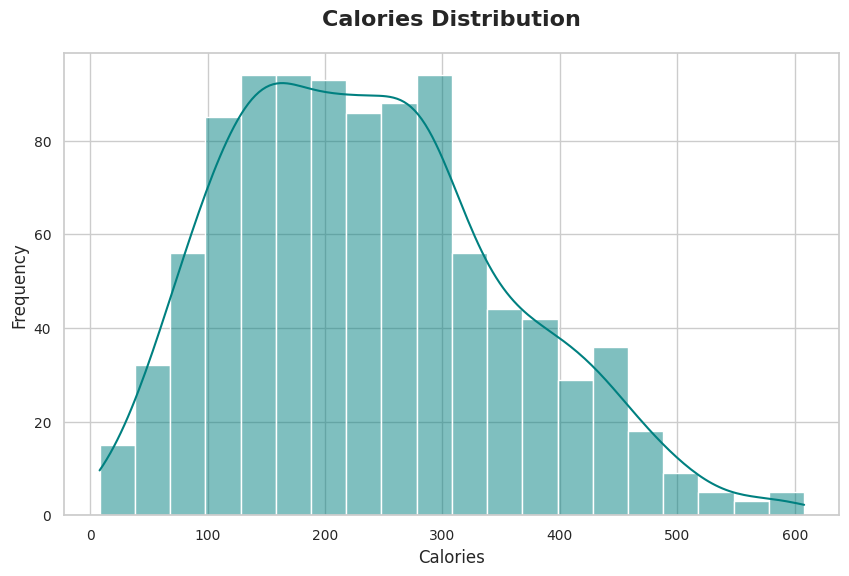

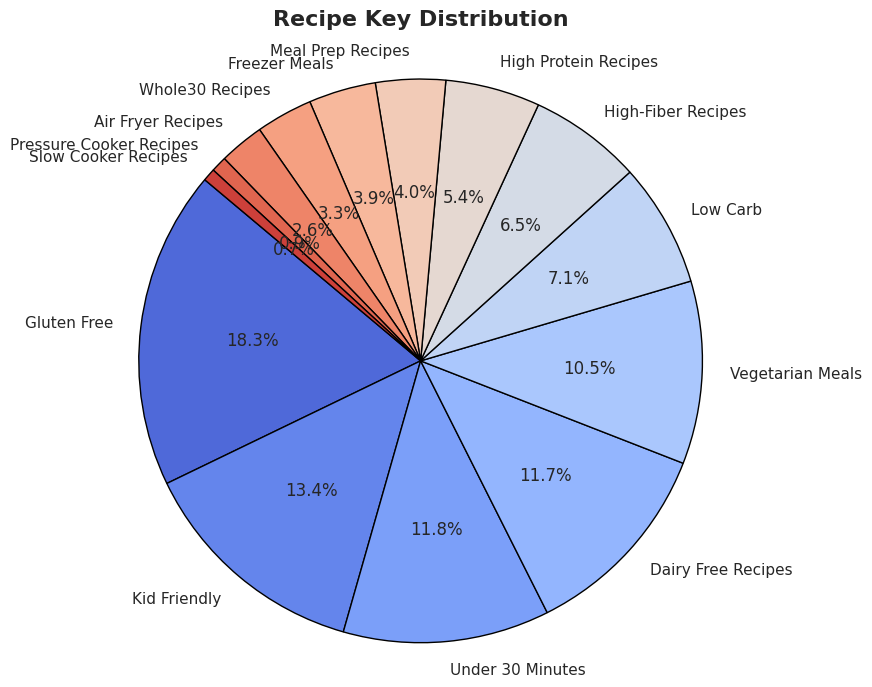

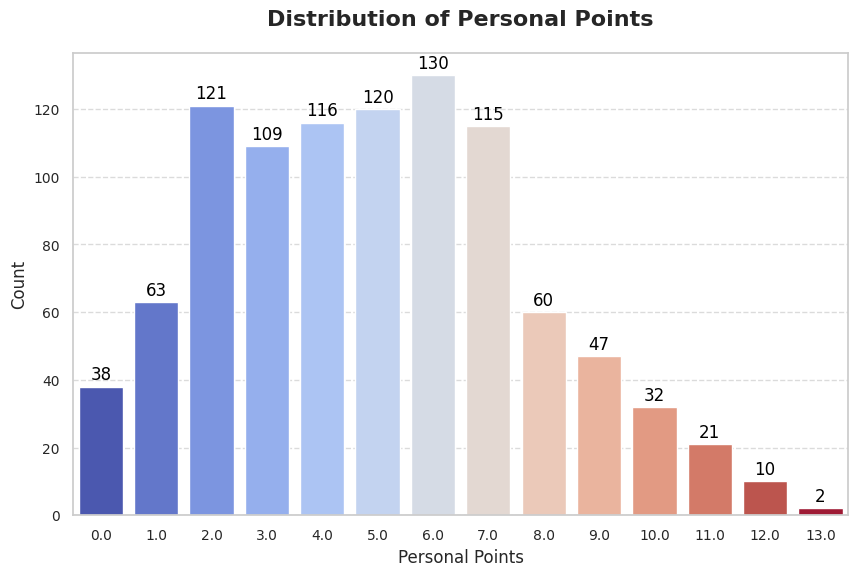

In [ ]:
sns.set(style="whitegrid")

#Calorie plot
plt.figure(figsize=(10, 6))
sns.histplot(recipes_df['calories'], bins=20, kde=True, color='teal')
plt.title('Calories Distribution', fontsize=16, fontweight='bold',pad=20)
plt.xlabel('Calories', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

# 2. Pie Chart for Recipe Key Distribution
plt.figure(figsize=(8, 8))

recipe_key_counts = recipes_df_exploded['recipe_keys'].value_counts()
plt.pie(recipe_key_counts, labels=recipe_key_counts.index, autopct='%1.1f%%',
        startangle=140, colors=sns.color_palette('coolwarm', len(recipe_key_counts)),
        wedgeprops={'edgecolor': 'black'})

plt.title('Recipe Key Distribution', fontsize=16, fontweight='bold',pad=20)
plt.axis('equal')
plt.show()


#Personal Points Plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(x='personal_points', hue='personal_points', data=recipes_df, palette='coolwarm', legend=False)
plt.title('Distribution of Personal Points', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Personal Points', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                       textcoords='offset points')
plt.show()

User Intraction :

In [ ]:
def filter_recipes_by_calories_and_points(calorie_range, points_range):
    min_calories, max_calories = calorie_range
    min_points, max_points = points_range

    filtered_recipes = recipes_df[
        (recipes_df['calories'] >= min_calories) &
        (recipes_df['calories'] <= max_calories) &
        (recipes_df['personal_points'] >= min_points) &
        (recipes_df['personal_points'] <= max_points)
    ]

    sorted_recipes = filtered_recipes.sort_values(by='calories').head(10)

    return sorted_recipes

def display_filtered_recipes(recipes):
    if recipes.empty:
        print("No recipes found for the given criteria.")
    else:
        for index, row in recipes.iterrows():
            print(f"Recipe Name: {row['name']}")
            print(f"Calories: {row['calories']}")
            print(f"Personal Points: {row['personal_points']}")
            print(f"Summary: {row['summary']}")

            try:
                display(Image(url=row['image_url'], width=300, height=200))
            except Exception as e:
                print(f"Error displaying image: {e}")

            print("\n" + "="*50 + "\n")

def get_user_input():
    min_calories = int(input("Enter the minimum number of calories: "))
    max_calories = int(input("Enter the maximum number of calories: "))

    min_points = int(input("Enter the minimum number of points: "))
    max_points = int(input("Enter the maximum number of points: "))

    return (min_calories, max_calories), (min_points, max_points)

def get_input():
    calorie_range, points_range = get_user_input()

    filtered_recipes = filter_recipes_by_calories_and_points(calorie_range, points_range)

    display_filtered_recipes(filtered_recipes)

get_input()

KeyboardInterrupt: Interrupted by user